<a href="https://colab.research.google.com/github/dgrifka/nfl_motion_coverage_overlap/blob/main/Model_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Predictions**

We're going to use the neural net that we trained in the `Model Training.ipynb` file to predict overlap intensity during pre-snap motion.

Much of the data preparation code is similar to the code in `Model Training.ipynb`, so if you have questions, then I suggest you start there first (https://github.com/dgrifka/nfl_motion_coverage_overlap).

In [ ]:
!git clone https://github.com/dgrifka/nfl_motion_coverage_overlap.git

import os

# Change this to the path of your repository
repo_path = '/content/nfl_motion_coverage_overlap'
os.chdir(repo_path)

# Import the necessary functions
%run setup.py

Cloning into 'nfl_motion_coverage_overlap'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 49 (delta 14), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 35.97 MiB | 22.31 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
players = read_nfl_csv('players')
games = read_nfl_csv('games')
plays_raw = read_nfl_csv('plays')
# Add team names and features, such as offense score differential
plays = process_nfl_plays(plays_raw, games)
player_play = read_nfl_csv('player_play')

# For pre-snap data
pre_snap = process_tracking_data(
    tracking_path=google_drive_path,
    snap_type="pre",
    weeks=range(1, 10)
)

In [ ]:
# For post-snap data
pre_snap_total = merge_tracking_data(pre_snap, plays, players, add_team_column)
pre_snap_total_normalized = normalize_direction(pre_snap_total)

In [ ]:
ball_df = get_initial_ball_position(pre_snap_total_normalized)

In [ ]:
# If you'd only like to train on a few games, then reduce the number below
n_games = 1000
# Get unique game IDs
game_ids = pre_snap_total_normalized.select('gameId').unique().head(n_games)

In [ ]:
# Get defensive players
def_presnap_df = filter_players_by_position(pre_snap_total_normalized, game_ids, 'defense')

# Get offensive players
off_presnap_df = filter_players_by_position(pre_snap_total_normalized, game_ids, 'offense')

# Add distance_from_football feature
def_presnap_df_with_distance = add_distance_from_football(def_presnap_df, ball_df)

# Add distance_from_football feature
off_presnap_df_with_distance = add_distance_from_football(off_presnap_df, ball_df)

In order to use/load the model we created previously, we need to define a function in this Colab file.

In [ ]:
def load_model_and_scalers(model_name, base_path='model/actual_models'):
    """
    Load a saved model and its scalers from individual files.

    Parameters:
        model_name (str): Name of the model ('offensive' or 'defensive')
        base_path (str): Base path where model files are stored
    """
    # Register the custom loss function
    tf.keras.utils.get_custom_objects()['route_aware_loss'] = route_aware_loss

    # Enable unsafe deserialization
    tf.keras.config.enable_unsafe_deserialization()

    # Construct full file paths
    model_path = os.path.join(base_path, f'{model_name}_model.keras')
    scalers_path = os.path.join(base_path, f'{model_name}_scalers.pkl')
    history_path = os.path.join(base_path, f'{model_name}_history.pkl')

    # Check if files exist
    for filepath in [model_path, scalers_path, history_path]:
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Could not find file: {filepath}")

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Load the scalers
    with open(scalers_path, 'rb') as f:
        scalers = pickle.load(f)

    # Load the history
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    return (
        model,
        (scalers['position_scaler'], scalers['context_scaler']),
        scalers['y_scaler'],
        history
    )

# Load offensive model and scalers
off_model, off_scaler_X, off_scaler_y, off_history = load_model_and_scalers('offensive')
# Load defensive model and scalers
def_model, def_scaler_X, def_scaler_y, def_history = load_model_and_scalers('defensive')

Next, we're going to randomly sample plays where the defense was in "Man" and 50 plays where the defense was in "Zone". Then, we're going to make overlap predictions for each play based on the pre-snap movement and save them as a csv, which we'll then upload to GitHub for future analysis.

In [ ]:
# # Make sure we're not duplicating analysis
# existing_manzone = pd.read_csv('/content/zone_man_previous.csv')
# existing_manzone.head()


Processing Zone coverage plays...


Zone Plays:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-2b1482d51544>:792: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))


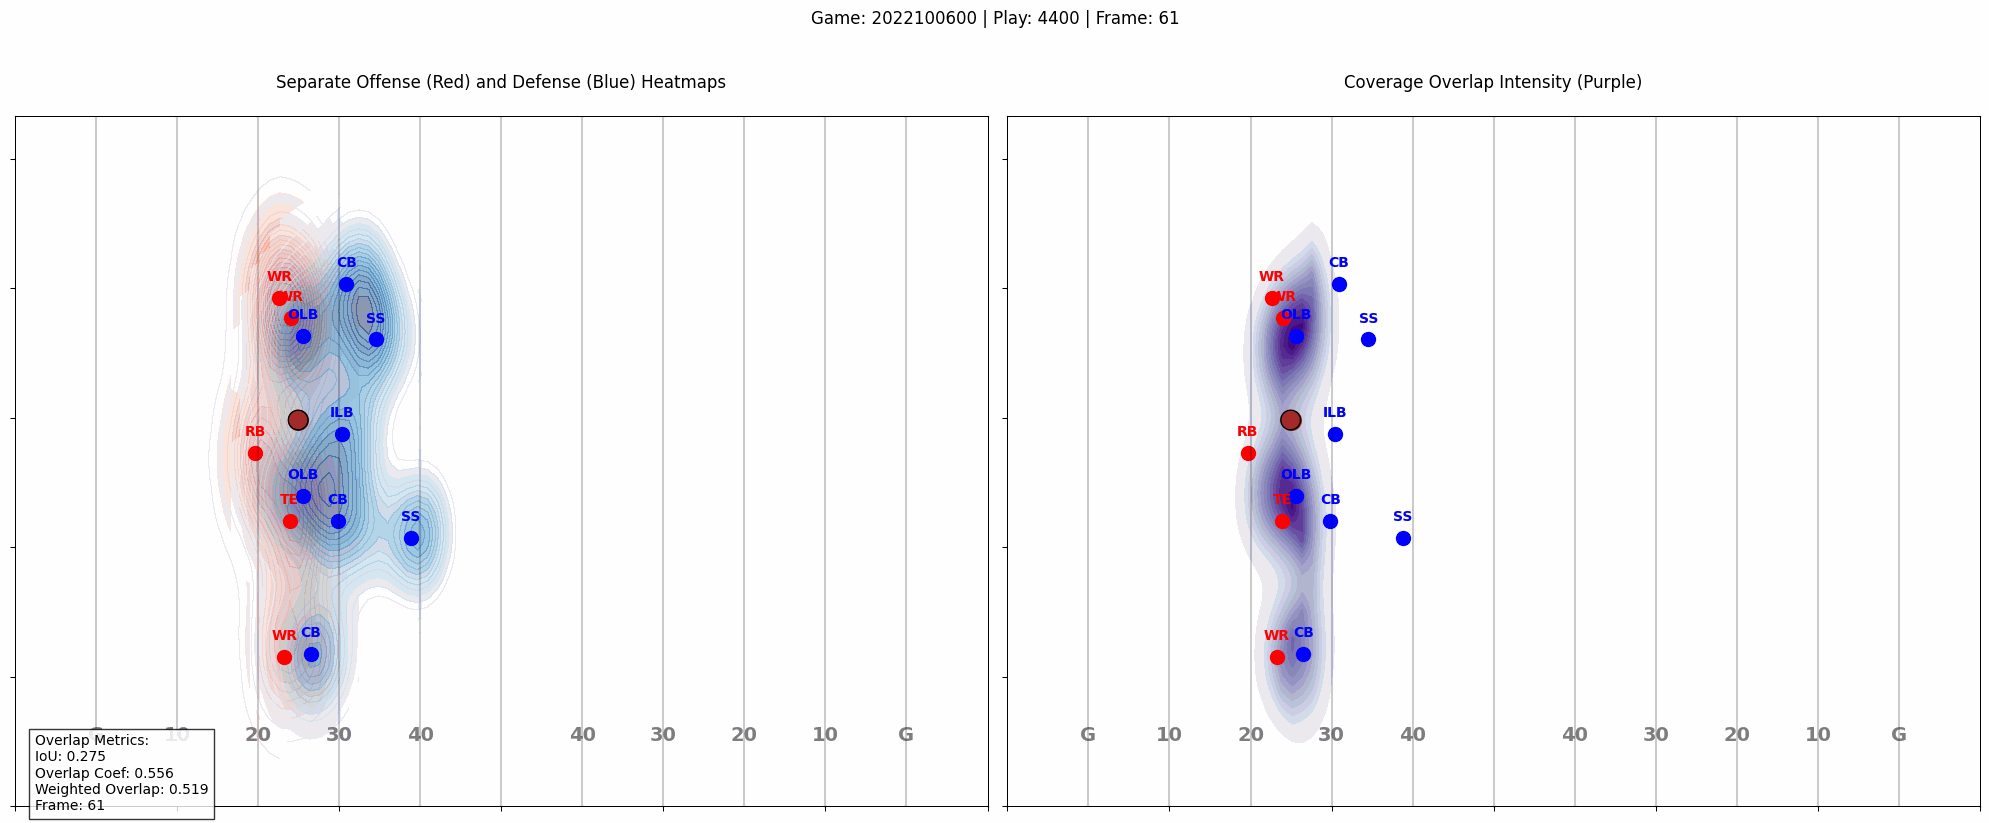

Zone Plays:   0%|          | 0/1 [03:54<?, ?it/s]


TypeError: 'tuple' object does not support item assignment

In [24]:
# Sample of Man and Zone plays
sampled_plays = sample_man_zone_plays(off_presnap_df_with_distance, n_samples=20)
# Can remove later
sampled_plays = filter_sampled_plays(existing_manzone, sampled_plays)

man_df = None
zone_df = None

# Loop through Man plays
print("Processing Man coverage plays...")
for game_id, play_id in tqdm(sampled_plays['man_plays'], desc='Man Plays'):
    # Create animation and get metrics
    man_overlap_df = create_route_overlap_animation(
        off_presnap_df_with_distance,
        def_presnap_df_with_distance,
        off_model,
        def_model,
        off_scaler_X,
        def_scaler_X,
        off_scaler_y,
        def_scaler_y,
        game_id=game_id,
        play_id=play_id,
        fps=4
    )
    man_overlap_df['pff_manZone'] = 'Man'

    if man_df is None:
        man_df = man_overlap_df
    else:
        man_df = pd.concat([man_df, man_overlap_df])

# Loop through Zone plays
print("\nProcessing Zone coverage plays...")
for game_id, play_id in tqdm(sampled_plays['zone_plays'], desc='Zone Plays'):
    # Create animation and get metrics
    zone_overlap_df = create_route_overlap_animation(
        off_presnap_df_with_distance,
        def_presnap_df_with_distance,
        off_model,
        def_model,
        off_scaler_X,
        def_scaler_X,
        off_scaler_y,
        def_scaler_y,
        game_id=game_id,
        play_id=play_id,
        fps=4
    )
    zone_overlap_df['pff_manZone'] = 'Zone'

    if zone_df is None:
        zone_df = zone_overlap_df
    else:
        zone_df = pd.concat([zone_df, zone_overlap_df])

# Concat zone_df and man_df
zone_man = pd.concat([zone_df, man_df])
zone_man.head()

In [ ]:
zone_man.to_csv('zone_man_overlap.csv', index=False)